# COSMO WCS

In [1]:
# Script for training a denoiser
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/11.1.0'

In [2]:
%pylab inline
from astropy.io import fits
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [3]:
root = '/linkhome/rech/genpuc01/utb76xl/jl/scripts/results/cosmos/annealed_hmc/seeds/samples_denoised_'
cosmos = fits.getdata(root+'1.fits')
cosmos = np.concatenate([cosmos, fits.getdata(root+'2.fits')], axis=0).reshape(-1,360,360)
cosmos = np.concatenate([cosmos, fits.getdata(root+'3.fits')], axis=0).reshape(-1,360,360)
for i in range(4, 51):
    if (i<11 or i>20):
        s = fits.getdata(root+str(i)+'.fits')
        cosmos = np.concatenate([cosmos, s], axis=0)
cosmos.shape

(400, 360, 360)

In [4]:
posterior_mean = cosmos.mean(axis=0)

In [5]:
from astropy.wcs import WCS

# create a fits map
res = 0.29/60

wcs_helix_list = WCS(naxis=2)
wcs_helix_list.wcs.crpix = [360//2, 360//2] # reference pixel point
wcs_helix_list.wcs.crval = [150.11, 2.24] # reference coordinates
wcs_helix_list.wcs.cunit = ["deg", "deg"]
wcs_helix_list.wcs.ctype = ["RA---TAN", "DEC--TAN"]
wcs_helix_list.wcs.cdelt = [res, res]
wcs_helix_list.array_shape = [360, 360]
wcs_helix_list

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 150.11  2.24  
CRPIX : 180.0  180.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.004833333333333333  0.004833333333333333  
NAXIS : 360  360

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

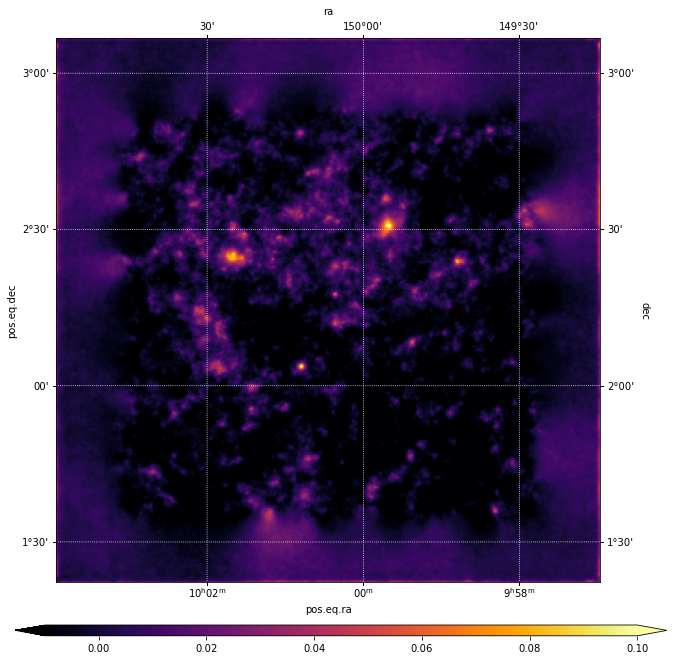

In [7]:
width = 360
resolution = 0.29

vmin = -.01
vmax = 0.1

kwargs = dict(cmap='inferno', vmin=vmin, vmax=vmax)

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs_helix_list)
im = ax.imshow(posterior_mean, origin='lower', aspect='equal', **kwargs)

#ax.invert_yaxis()
ax.invert_xaxis()
#plt.xlabel(r'RA')
#plt.ylabel(r'Dec')

overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

cbar_ax = fig.add_axes([.078, 0.05, .905, 0.015])
cb = fig.colorbar(im, cax=cbar_ax, extend='both', orientation="horizontal")
#cb.ax.tick_params(labelsize=18)

In [8]:
data = posterior_mean
header = wcs_helix_list.to_header()
hdu = fits.PrimaryHDU(data=data, header=header)

In [9]:
hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  360                                                  
NAXIS2  =                  360                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                180.0 / Pixel coordinate of reference point            
CRPIX2  =                180.0 / Pixel coordinate of reference point            
CDELT1  =   0.0048333333333333 / [deg] Coordinate increment at reference point  
CDELT2  =   0.0048333333333333 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'        

## Massey COSMOS map

In [10]:
massey = fits.getdata('cosmos_e.fits')
massey.shape

(477, 492)

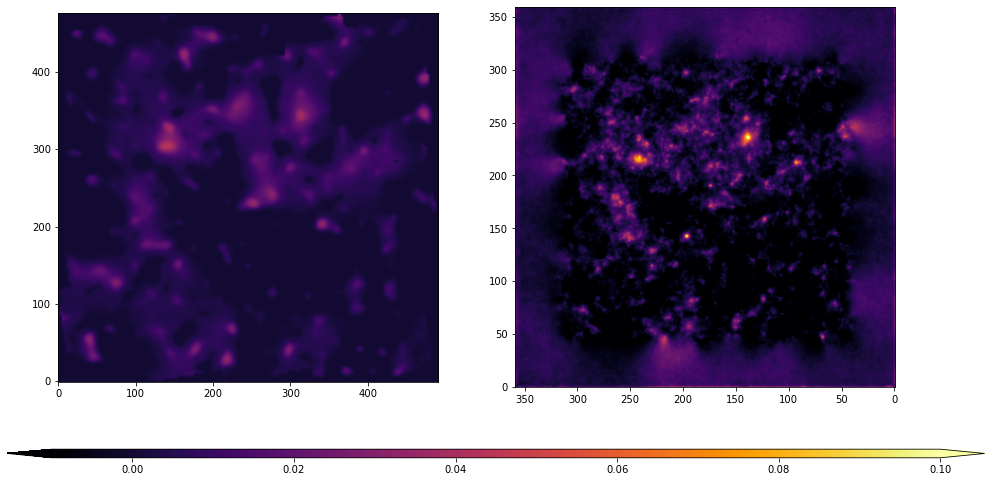

In [11]:
width = 360
resolution = 0.29

vmin = -.01
vmax = 0.1

kwargs = dict(cmap='inferno', vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(1,2, figsize=(15,8))
#ax = plt.add_subplot(1,1,1)
im = ax[0].imshow(massey, origin='lower', aspect='equal', **kwargs)
#ax.invert_yaxis()
#ax[0].invert_xaxis()

im = ax[1].imshow(posterior_mean, origin='lower', aspect='equal', **kwargs)
#ax.invert_yaxis()
ax[1].invert_xaxis()

#overlay = ax.get_coords_overlay('icrs')
#overlay.grid(color='white', ls='dotted')

cbar_ax = fig.add_axes([.078, 0.05, .905, 0.015])
cb = fig.colorbar(im, cax=cbar_ax, extend='both', orientation="horizontal")
#cb.ax.tick_params(labelsize=18)

In [12]:
# not the same scale yet ^^^^